In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import xgboost

# Loading final.csv

In [2]:
df = pd.read_csv('final.csv', low_memory = False, index_col=0)
df.head()

C:\Users\janlu\AppData\Roaming\Python\Python35\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Nombre pieces principales,Valeur fonciere,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degr̩ de densit̩,Part population dense (1),Part population interm̩diaire (2),Part population peu dense (3),Part population tr̬s peu dense (4),Longitude,Latitude
0,2,240000,1,2014,1,1,7459.0,22316.0,0.0,2.0,0.0,0.624,0.364,0.012,5.717,43.333
1,3,43000,1,2014,1,1,9611.0,18267.0,0.0,3.0,0.0,0.000,0.707,0.293,0.162,45.959
2,2,240000,1,2014,1,1,7459.0,22316.0,0.0,2.0,0.0,0.624,0.364,0.012,5.717,43.333
3,4,73000,1,2014,1,2,1157.0,18233.0,0.0,3.0,0.0,0.000,0.865,0.135,1.564,42.764
4,5,150000,1,2014,1,2,12900.0,18641.0,0.0,2.0,0.0,0.450,0.354,0.197,2.567,49.650


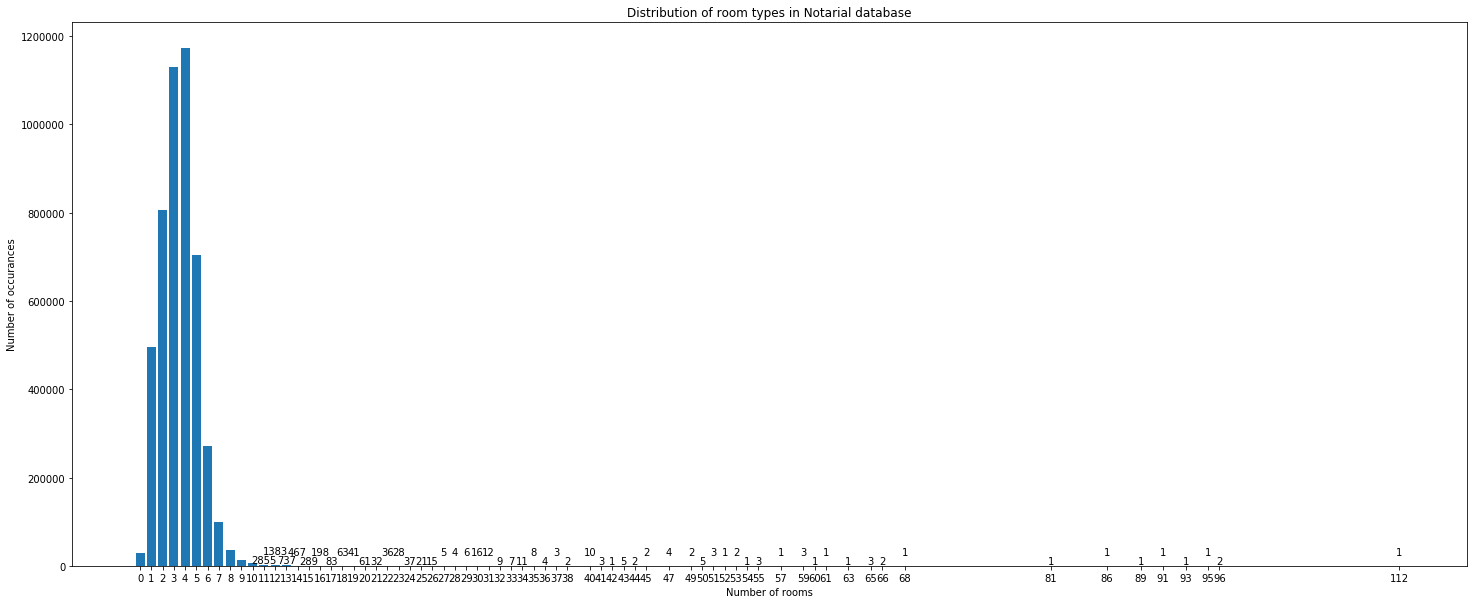

In [ ]:
Y = df['Nombre pieces principales']

plt.figure(figsize=(25,10))
bars = plt.bar(Y.value_counts().index, list(Y.value_counts()))

i = 0
for rect in bars:
    if rect.get_height() < 5000:
        h = 20000**(i%2)
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height+h, '%d' % int(height), ha='center', va='bottom')
        i += 1

plt.xlabel('Number of rooms')
plt.ylabel('Number of occurances')
plt.title('Distribution of room types in Notarial database')
#plt.grid(True)
plt.xticks(Y.value_counts().index)
#plt.savefig('Distribution of room types in Notarial database.png', dpi=200)
plt.show()
plt.close()

# Initial class reduction - forming "9+" class

There is a lrage "tail" of the (relatively) normal distribution of classes in form of hunders or thousands flats/apratments with number of rooms larger than 9. Our suggestion is not to delete them, but to immediately aggregate them into a composite class "9+", together with 9-roomed properties.
### This will be denoted as 9 in the rest of the notebook (for it to remain numeric value in the data)

In [ ]:
# Redefining classes into 0,1,2,3,4,5,6,7,8,9+

Y = list(Y)

for i, m in enumerate(Y):
    if m >= 9:
        Y[i] = 9

df.drop('Nombre pieces principales', axis = 1, inplace = True)
df.insert(loc=0, column='Nombre pieces principales', value=Y)

del Y
df.head()

In [ ]:
Y = df['Nombre pieces principales']

plt.figure(figsize=(25,10))
bars = plt.bar(Y.value_counts().index, list(Y.value_counts()))

i = 0
for rect in bars:
    if rect.get_height() < 5000:
        h = 20000**(i%2)
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height+h, '%d' % int(height), ha='center', va='bottom')
        i += 1

plt.xlabel('Number of rooms')
plt.ylabel('Number of occurances')
plt.title('Distribution of room types in Notarial database')
#plt.grid(True)
plt.xticks(Y.value_counts().index)
#plt.savefig('Distribution of room types in Notarial database.png', dpi=200)
plt.show()
plt.close()

del Y

# Test-train split and first model

In [ ]:
def split_data_in_two(df, r_s):
    X = df.iloc[:,1:].to_numpy(copy=True)
    Y = df.iloc[:,0].to_numpy(copy=True)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=r_s)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data_in_two(df, 42)

### Checking if stratification works correctly

In [ ]:
Y = pd.Series(y_train)

plt.figure(figsize=(25,10))
bars = plt.bar(Y.value_counts().index, list(Y.value_counts()))

plt.xlabel('Number of rooms')
plt.ylabel('Number of occurances')
plt.title('Distribution of room types in Notarial database')
#plt.grid(True)
plt.xticks(Y.value_counts().index)
#plt.savefig('Distribution of room types in Notarial database.png', dpi=200)
plt.show()
plt.close()

del Y

In [ ]:
Y = pd.Series(y_test)

plt.figure(figsize=(25,10))
bars = plt.bar(Y.value_counts().index, list(Y.value_counts()))

plt.xlabel('Number of rooms')
plt.ylabel('Number of occurances')
plt.title('Distribution of room types in Notarial database')
#plt.grid(True)
plt.xticks(Y.value_counts().index)
#plt.savefig('Distribution of room types in Notarial database.png', dpi=200)
plt.show()
plt.close()

del Y

Distributions look very similar, therefore stratification when splitting the data is working well. Now we can move onto training the first model.

### Training first model

In [ ]:
clf1 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42, n_jobs=-1)
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()

### From the confusion matrix we can see that the class imbalance is probably causing overprediction of most common classes.



## We need to assign weights in the model to our classes. Let's use "balanced_subsample" option.

In [ ]:
clf2 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42, n_jobs=-1, class_weight='balanced_subsample')
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()

### Now we have the opposite problem.



## Let's use "balanced" option.

In [ ]:
clf3 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42, n_jobs=-1, class_weight='balanced')
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()

## Let's try a different model - calibrated forest

### First without class weights

In [ ]:
clf4 = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42, n_jobs=-1), method='isotonic')
clf4.fit(X_train, y_train)
y_pred = clf4.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()

### Now with wieghts. Let's use "balanced" option, since it performed better with uncallibrate random forest.

In [ ]:
clf5 = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42, n_jobs=-1, class_weight='balanced'), method='isotonic')
clf5.fit(X_train, y_train)
y_pred = clf5.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()

# XGBOOST

With default hyperparameter settings.

In [ ]:
model = xgboost.XGBClassifier(base_score =1/10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()

## XGBOOST with GridSearch

This can be run to optimize hyperparameters. It will however run for 1-2 days on a powerful laptop. Should only be run if xgboost model is selected with current data set configuration (eg. current classes)

In [ ]:
'''max_depth = [3,5,6,8]
n_estimators = [20, 50, 100, 200]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
gamma = [0.001, 0.01, 0.1, 1]
min_child_weight = [1, 2, 3]
booster = ['gbtree']
base_score = [1/10]

model2 = xgboost.XGBClassifier()

hyperF = dict(max_depth = max_depth, n_estimators = n_estimators, learning_rate = learning_rate, booster = booster, base_score = base_score, gamma = gamma, min_child_weight = min_child_weight)

gridF = GridSearchCV(model2, hyperF, scoring = 'average_precision', cv = 3, verbose = 2, n_jobs = -1, refit=True)
bestF = gridF.fit(X_train, y_train)
y_pred = bestF.predict(X_test)'''

In [ ]:
'''plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()'''

# Let's try regrouping classes and repeat the process

We can try grouping all classes with lots of rooms into 7+ group and see what happens. It should give us more balanced classes.
Also let's group together 0 and 1, for the same reason.

In [ ]:
df = pd.read_csv('final.csv', low_memory = False, index_col=0)
df.head()

In [ ]:
# Redefining classes into -1,2,3,4,5,6,7+

Y = df['Nombre pieces principales']

Y = list(Y)

for i, m in enumerate(Y):
    if m >= 7:
        Y[i] = 7
    elif m <= 1:
        Y[i] = 1

df.drop('Nombre pieces principales', axis = 1, inplace = True)
df.insert(loc=0, column='Nombre pieces principales', value=Y)

del Y
df.head()

In [ ]:
Y = df['Nombre pieces principales']

plt.figure(figsize=(25,10))
bars = plt.bar(Y.value_counts().index, list(Y.value_counts()))

i = 0
for rect in bars:
    if rect.get_height() < 5000:
        h = 20000**(i%2)
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height+h, '%d' % int(height), ha='center', va='bottom')
        i += 1

plt.xlabel('Number of rooms')
plt.ylabel('Number of occurances')
plt.title('Distribution of room types in Notarial database')
#plt.grid(True)
plt.xticks(Y.value_counts().index)
#plt.savefig('Distribution of room types in Notarial database.png', dpi=200)
plt.show()
plt.close()

del Y

In [ ]:
def split_data_in_two(df, r_s):
    X = df.iloc[:,1:].to_numpy(copy=True)
    Y = df.iloc[:,0].to_numpy(copy=True)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=r_s)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data_in_two(df, 42)

## RandomForest with "balanced" class weights

In [ ]:
clf6 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42, n_jobs=-1, class_weight='balanced')
clf6.fit(X_train, y_train)
y_pred = clf6.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()

## XGBOOST with "balanced" class weights

In [ ]:
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()

## XGBOOST with "balanced" class weights and small GridSearch hyperparameter optimization

In [ ]:
max_depth = [6,8]
n_estimators = [50, 200]
learning_rate = [0.01, 0.1, 0.3]
gamma = [0.001, 0.1]
min_child_weight = [1, 3]
booster = ['gbtree']
base_score = [1/7]

model2 = xgboost.XGBClassifier()

hyperF = dict(max_depth = max_depth, n_estimators = n_estimators, learning_rate = learning_rate, booster = booster, base_score = base_score, gamma = gamma, min_child_weight = min_child_weight)

gridF = GridSearchCV(model2, hyperF, scoring = 'average_precision', cv = 3, verbose = 2, n_jobs = -1, refit=True)
bestF = gridF.fit(X_train, y_train)
y_pred = bestF.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=list(np.unique(y_train)), normalize=True, title='Normalized confusion matrix')
plt.show()